     0    1    2    3    4    5    6    7    8   9   ...   74   75   76   77  \
0   127  105  103   99  111  111  101  103  101   0  ...  107  109  107  103   
1   127  105  103   99  111  111  101  103  101   0  ...  107  109  107  103   
2   127  105  103   99  111  111  101  101  101   0  ...  107  109  107  103   
3   127  105  103   99  111  111  101  101  101   0  ...  107  109  107  103   
4   127  105  103   99  111  111  101  101   99   0  ...  107  109  107  103   
5   127  105  103   99  111  111  101  101  101   0  ...  107  109  107  103   
6   127  105  101   99  111  111  101  101  101   0  ...  107  109  107  103   
7   127  105  103   99  111  111  101  101  101   0  ...  107  109  107  103   
8   127  105  103   99  111  111  101  101  101   0  ...  107  107  107  103   
9   127  105  103   99  111  111  101  103  101   0  ...  107  109  107  103   
10  127  105  103   99  111  111  101  103  101   0  ...  107  109  107  103   
11  127  105  103   99  111  111  101  1

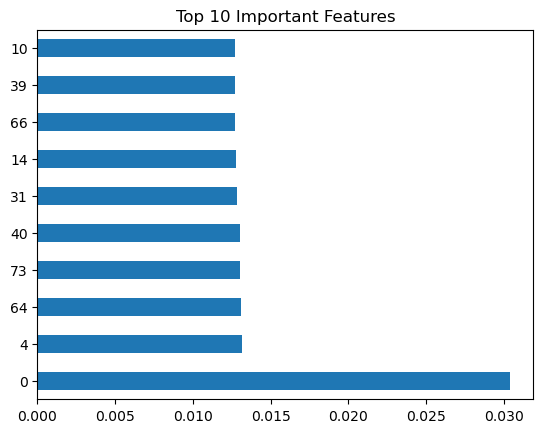

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных из файла
data = np.fromfile(r'YOUR PATH\captured_data.bin', dtype='B', count=-1)
data = data.reshape(-1, 84)
data = pd.DataFrame(data)


print(data.head(20))  # Исправлено: df -> data


scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data))

# Метки классов
y = (scaled_data[0] > 0.6).astype(int)  # Класс 1, если значение первого признака > 0.6, иначе класс 0

# Добавление случайного шума к данным (т.к. обучение идет на реальных данных, в следующих версиях следует убрать шум)
noise_factor = 0.05
noise = np.random.normal(0, noise_factor, data.shape)
data_noisy = data + noise * 256

data_noisy = np.clip(data_noisy, 0, 255).astype('uint8')
df_noisy = pd.DataFrame(data_noisy)

# Масштабирование данных после добавления шума
scaled_data_noisy = pd.DataFrame(scaler.fit_transform(df_noisy))

X = scaled_data_noisy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Random Forest
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV-оптимизация
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Определение лучшей модели
best_rf = random_search.best_estimator_

# Точность (Accuracy)
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)  # Исправлено: scaled_data -> X
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

print("Best Hyperparameters:", random_search.best_params_)